# Movie Recommendation


<a href="https://colab.research.google.com/github/myscale/examples/blob/main/movie-recommendation.ipynb" style="padding-left: 0.5rem;"><img src="https://colab.research.google.com/assets/colab-badge.svg?style=plastic)](https://colab.research.google.com/github/myscale/examples/blob/main/movie-recommendation.ipynb)"></a>
<a href="https://github.com/myscale/examples/blob/main/movie-recommendation.ipynb" style="padding-left: 0.5rem;"><img src="https://img.shields.io/badge/Open-Github-blue.svg?logo=github&style=plastic)](https://github.com/myscale/examples/blob/main/movie-recommendation.ipynb)"></a>

## Introduction

A recommendation system is a subclass of information filtering system that provides suggestions for items that are most pertinent to a particular user. To suggest the most suitable option from a range of possibilities, these systems use algorithms. Various techniques and algorithms such as collaborative filtering, matrix factorization, and deep learning are utilized to implement a recommendation system.

This guide will demonstrate how to construct a basic recommendation system using MyScale. The process comprises several stages, including the construction of user and item vectors based on the NMF model, the insertion of datasets into MyScale, the retrieval of top K recommended items for a user, and the use of an SVD model to predict user ratings for MyScale's suggested items.

If you are more interested in exploring the capabilities of MyScale, you may skip the [Building Datasets](#building-datasets) section and dive right into the [Populating data to MyScale section](#populating-data-to-myscale).

## Prerequisites

To begin with, certain dependencies must be installed, including [clickhouse python client](https://clickhouse.com/docs/en/integrations/language-clients/python/intro/), scikit-learn, and other relevant tools.

In [1]:
!pip install -U clickhouse-connect scikit-learn

## Building Datasets

### Downloading and processing data

For this example, we will employ the small datasets at [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/) to provide movie recommendations. The dataset comprises 100,000 ratings applied to 9,000 movies by 600 users.

In [2]:
!curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip --output ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0   368k      0  0:00:02  0:00:02 --:--:--  368k


In [3]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Let's read data into pandas dataframe.

In [4]:
import pandas as pd

# obtain movie metadata
original_movie_metadata = pd.read_csv('ml-latest-small/movies.csv')
movie_metadata = original_movie_metadata[['movieId', 'title', 'genres']]
movie_metadata['genres'] = movie_metadata['genres'].str.split('|', expand=False)

# add tmdbId to movie metadata dataframe
original_movie_links = pd.read_csv('ml-latest-small/links.csv')
movie_info = pd.merge(movie_metadata, original_movie_links, on=["movieId"])[['movieId', 'title', 'genres', 'tmdbId']]

# filter tmdb valid movies
movie_info = movie_info[movie_info['tmdbId'].notnull()]
movie_info['tmdbId'] = movie_info['tmdbId'].astype(int).astype(str)
movie_info.head()

,movieId,title,genres,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",862
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",8844
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",15602
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",31357
4,5,Father of the Bride Part II (1995),[Comedy],11862


In [5]:
# get movie user rating info
movie_user_rating = pd.read_csv('ml-latest-small/ratings.csv')

# remove ratings of movies which don't have tmdbId
movie_user_rating = movie_user_rating[movie_user_rating['movieId'].isin(movie_info['movieId'])]
movie_user_rating = movie_user_rating[["userId", "movieId", "rating"]]
movie_user_rating.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [6]:
movie_user_rating.nunique()

userId      610
movieId    9716
rating       10
dtype: int64

### Generating user and movie vectors

Non-negative Matrix Factorization (NMF) is a matrix factorization technique that decomposes a non-negative matrix `R` into two non-negative matrices `W` and `H`, where `R ≈ WH`. NMF is a commonly used technique in recommender systems for extracting latent features from high-dimensional sparse data such as user-item interaction matrices.

In a recommendation system context, NMF can be utilized to factorize the user-item interaction matrix into two low-rank non-negative matrices: one matrix represents users' preferences for the latent features, and the other matrix represents how each item is related to these latent features. Given a user-item interaction matrix `R` of size `m` x `n`, we can factorize it into two non-negative matrices W and H, such that R is approximated by their product: `R ≈ W * H`. The factorization is achieved by minimizing the distance between `R` and `W * H`, subject to the non-negative constraints on `W` and `H`.

The `W` and `H` matrices correspond to the user vector matrix and item vector matrix, respectively, and can be used as vector indices for queries later.

Let's start with creating a user-item matrix for movie ratings first, where each row represents a user and each column represents a movie. Each cell in the matrix represents the corresponding user rating for that movie. If a user has not rated a particular movie, the cell value will be set to 0.

In [7]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix

user_indices, user_ids = pd.factorize(movie_user_rating['userId'])
item_indices, movie_ids = pd.factorize(movie_user_rating['movieId'])
rating_sparse_matrix = csr_matrix((movie_user_rating['rating'], (user_indices, item_indices)))

# normalize matrix with MaxAbsScaler
max_abs_scaler = MaxAbsScaler()
rating_sparse_matrix = max_abs_scaler.fit_transform(rating_sparse_matrix)

After building our user-item matrix, we can fit NMF model with the matrix.

In [8]:
# create NMF model with settings
dimension = 512
nmf_model = NMF(n_components=dimension, init='nndsvd', max_iter=500)

# rating sparse matrix decomposition with NMF
user_vectors = nmf_model.fit_transform(rating_sparse_matrix)
item_vectors = nmf_model.components_.T

error = nmf_model.reconstruction_err_
print("Reconstruction error: ", error)

Reconstruction error:  31.316179423055555


In [9]:
# generate user vector matrix, containing userIds and user vectors
user_vector_df = pd.DataFrame(zip(user_ids, user_vectors), columns=['userId', 'user_rating_vector']).reset_index(drop=True)

# generate movie vector matrix, containing movieIds and movie vectors
movie_rating_vector_df = pd.DataFrame(zip(movie_ids, item_vectors), columns=['movieId', 'movie_rating_vector'])

### Creating Datasets

We now have four dataframes: movie metadata, user movie ratings, user vectors and movie vectors. We will merge the relevant dataframes into a single dataframe.

In [10]:
user_rating_df = movie_user_rating.reset_index(drop=True)
# add movie vectors into movie metadata and remove movies without movie vector
movie_info_df = pd.merge(movie_info, movie_rating_vector_df, on=["movieId"]).reset_index(drop=True)
movie_info_df.head()

,movieId,title,genres,tmdbId,movie_rating_vector
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",862,"[0.43727969455469096, 0.5435853936931008, 0.0,..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",8844,"[0.3812919324223999, 0.0, 0.0, 0.0, 0.13988881..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",15602,"[0.6578283373638811, 0.0, 0.0, 0.9922804828007..."
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",31357,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5,Father of the Bride Part II (1995),[Comedy],11862,"[0.31088958180836535, 0.0, 0.0, 0.0, 0.0699447..."


In [11]:
import pyarrow as pa
import pyarrow.parquet as pq

# create table objects from the data and schema
movie_table = pa.Table.from_pandas(movie_info_df)
user_table = pa.Table.from_pandas(user_vector_df)
rating_table = pa.Table.from_pandas(user_rating_df)

# write the table to parquet files
pq.write_table(movie_table, 'movie.parquet')
pq.write_table(user_table, 'user.parquet')
pq.write_table(rating_table, 'rating.parquet')

## Populating Data to MyScale

###  Loading data

To populate data to MyScale, first, we load data from the HuggingFace Dataset [myscale/recommendation-examples](https://huggingface.co/datasets/myscale/recommendation-examples) created in the previous section. The following code snippet shows how to load data and transform them into panda DataFrames.

In [1]:
from datasets import load_dataset

movie = load_dataset("myscale/recommendation-examples", data_files="movie.parquet", split="train")
user = load_dataset("myscale/recommendation-examples", data_files="user.parquet", split="train")
rating = load_dataset("myscale/recommendation-examples", data_files="rating.parquet", split="train")

# transform datasets to panda Dataframe
movie_info_df = movie.to_pandas()
user_vector_df = user.to_pandas()
user_rating_df = rating.to_pandas()

# convert embedding vectors from np array to list
movie_info_df['movie_rating_vector'] = movie_info_df['movie_rating_vector'].apply(lambda x: x.tolist())
user_vector_df['user_rating_vector'] = user_vector_df['user_rating_vector'].apply(lambda x: x.tolist())

Found cached dataset parquet (/Users/guanxiaoyao/.cache/huggingface/datasets/myscale___parquet/myscale--recommendation-examples-cada9fb4a7f7e92a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/Users/guanxiaoyao/.cache/huggingface/datasets/myscale___parquet/myscale--recommendation-examples-a4e48372fb027471/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/Users/guanxiaoyao/.cache/huggingface/datasets/myscale___parquet/myscale--recommendation-examples-4a978546f49558d3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


### Creating table

Next, we'll create tables in MyScale. 

Before you begin, you will need to retrieve your cluster host, username, and password information from the MyScale console. The following code snippet creates three tables, for movie metadata, user vectors, and user movie ratings.

In [2]:
import clickhouse_connect

# initialize client
client = clickhouse_connect.get_client(
    host='YOUR_CLUSTER_HOST', 
    port=8443, 
    username='YOUR_USERNAME', 
    password='YOUR_CLUSTER_PASSWORD'
)

In [3]:
client.command("DROP TABLE IF EXISTS default.myscale_movies")
client.command("DROP TABLE IF EXISTS default.myscale_users")
client.command("DROP TABLE IF EXISTS default.myscale_ratings")

# create table for movies
client.command(f"""
CREATE TABLE default.myscale_movies
(
    movieId Int64,
    title String,
    genres Array(String),
    tmdbId String,
    movie_rating_vector Array(Float32),
    CONSTRAINT vector_len CHECK length(movie_rating_vector) = 512
)
ENGINE = MergeTree ORDER BY movieId
""")

# create table for user vectors
client.command(f"""
CREATE TABLE default.myscale_users
(
    userId Int64,
    user_rating_vector Array(Float32),
    CONSTRAINT vector_len CHECK length(user_rating_vector) = 512
)
ENGINE = MergeTree ORDER BY userId
""")

# create table for user movie ratings
client.command("""
CREATE TABLE default.myscale_ratings
(
    userId Int64,
    movieId Int64,
    rating Float64
)
ENGINE = MergeTree ORDER BY userId
""")

''

### Uploading Data

After creating the tables, we insert data loaded from the datasets into tables

In [4]:
client.insert("default.myscale_movies", movie_info_df.to_records(index=False).tolist(), column_names=movie_info_df.columns.tolist())
client.insert("default.myscale_users", user_vector_df.to_records(index=False).tolist(), column_names=user_vector_df.columns.tolist())
client.insert("default.myscale_ratings", user_rating_df.to_records(index=False).tolist(), column_names=user_rating_df.columns.tolist())

# check count of inserted data
print(f"movies count: {client.command('SELECT count(*) FROM default.myscale_movies')}")
print(f"users count: {client.command('SELECT count(*) FROM default.myscale_users')}")
print(f"ratings count: {client.command('SELECT count(*) FROM default.myscale_ratings')}")

movies count: 9716
users count: 610
ratings count: 100823


### Building Index

Now, our datasets are uploaded to MyScale. We will create a vector index to accelerate vector search after inserting datasets.

We used HNSWFLAT as our vector search algorithm. For configuration details please refer to [Vector Reference](https://docs.myscale.com/en/vector-reference/).

The inner product is used as the distance metric here. Specifically, the inner product between the query vector(representing a user's preferences) and the item vectors(representing movie features) yields the cell values in the matrix `R`, which can be approximated by the product of the matrices `W` and `H` as mentioned in the section [Generating user and movie vectors](#generating-user-and-movie-vectors).

In [5]:
# create vector index with cosine
client.command("""
ALTER TABLE default.myscale_movies 
ADD VECTOR INDEX movie_rating_vector_index movie_rating_vector
TYPE HNSWFLAT('metric_type=ip')
""")

''

In [6]:
 # check the status of the vector index, make sure vector index is ready with 'Built' status
get_index_status="SELECT status FROM system.vector_indices WHERE name='movie_rating_vector_index'"
print(f"index build status: {client.command(get_index_status)}")

index build status: Built


## Query MyScale

### Performing query for movie recommendation

Randomly selecting a user as the target user for whom we recommend movies, and obtain the user rating histogram, which exhibits the distribution of user ratings.

currently selected user id=526 for movie recommendation

Distribution of ratings for user 526:


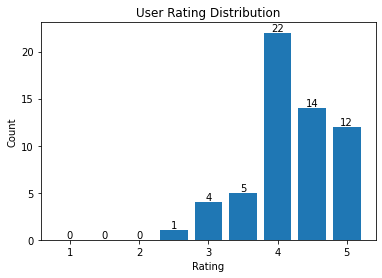

In [7]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

random_user = client.query("SELECT * FROM default.myscale_users ORDER BY rand() LIMIT 1")
assert random_user.row_count == 1
target_user_id = random_user.first_item["userId"]
target_user_vector = random_user.first_item["user_rating_vector"]

print("currently selected user id={} for movie recommendation\n".format(target_user_id))

# user rating plot
target_user_ratings = user_rating_df.loc[user_rating_df['userId'] == target_user_id]['rating'].tolist()
bins = np.arange(1.0, 6, 0.5)

# Compute the histogram
hist, _ = np.histogram(target_user_ratings, bins=bins)

print("Distribution of ratings for user {}:".format(target_user_id))
plt.bar(bins[:-1], hist, width=0.4)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('User Rating Distribution')
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(hist[i]), ha='center', va='bottom')
plt.show()

Next, let's recommend movies for the user.

As described in [Generating user and movie vectors](#generating-user-and-movie-vectors) and [Building Index](#building-index) sections, our user and movie vectors are extracted from the NMF model, and the inner products of vectors serve as our vector distance metrics. The formula of inner product of two vectors can be  simplified as follows:

$$\langle \mathbf{u}, \mathbf{v} \rangle = \sum_{i=1}^{n} u_i v_i = u_1 v_1 + u_2 v_2 + \cdots + u_n v_n$$

More specifically, we can obtain an approximated user-rating matrix using the inner product of the user vector matrix and the movie vector matrix based on NMF model. The value of the cell located at `(i, j)` represents the estimated rating of user `i` to movie `j`. Therefore, the distances between user vectors and movie vectors, represented by their inner products, can be used to recommend movies to users. Higher distances correspond to higher estimated movie ratings. 

However, since we normalized the rating matrix in previous sections, we still need to scale the distances to the new rating scale `(0, 5)`.

In [8]:
top_k = 10
# query the database to find the top K recommende
# d movies
recommended_results = client.query(f"""
SELECT movieId, title, genres, tmdbId, distance(movie_rating_vector, {target_user_vector}) AS dist
FROM default.myscale_movies
WHERE movieId not in (
    SELECT movieId
    from default.myscale_ratings
    where userId = {target_user_id}
    )
ORDER BY dist DESC
LIMIT {top_k}
""")

recommended_movies = pd.DataFrame.from_records(recommended_results.named_results())
rated_score_scale = client.query(f"""
SELECT max(rating) AS max, min(rating) AS min
FROM default.myscale_ratings
WHERE userId = {target_user_id}
""")
max_rated_score = rated_score_scale.first_row[0]
min_rated_score = rated_score_scale.first_row[1]

print("Top 10 movie recommandations with estimated ratings for user {}".format(target_user_id))
max_dist = recommended_results.first_row[4]
recommended_movies['estimated_rating'] = min_rated_score + ((max_rated_score - min_rated_score) / max_dist) * recommended_movies['dist']
recommended_movies[['movieId', 'title', 'estimated_rating', 'genres']]

Top 10 movie recommandations with estimated ratings for user 526


,movieId,title,estimated_rating,genres
0,158966,Captain Fantastic (2016),5.000000,[Drama]
1,110,Braveheart (1995),4.006175,"[Action, Drama, War]"
2,6539,Pirates of the Caribbean: The Curse of the Bla...,3.985674,"[Action, Adventure, Comedy, Fantasy]"
3,8874,Shaun of the Dead (2004),3.944620,"[Comedy, Horror]"
4,122918,Guardians of the Galaxy 2 (2017),3.726271,"[Action, Adventure, Sci-Fi]"
5,454,"Firm, The (1993)",3.668470,"[Drama, Thriller]"
6,708,"Truth About Cats & Dogs, The (1996)",3.568285,"[Comedy, Romance]"
7,6333,X2: X-Men United (2003),3.534327,"[Action, Adventure, Sci-Fi, Thriller]"
8,457,"Fugitive, The (1993)",3.523147,[Thriller]
9,141,"Birdcage, The (1996)",3.508386,[Comedy]


Compile a list of genres for the top 10 highest-rated movies and top 10 recommended movies to ascertain the similarity of their movie genres.

In [9]:
# count rated movies
rated_count = len(user_rating_df[user_rating_df["userId"] == target_user_id])

# query the database to find the top K recommended watched movies for user
rated_results = client.query(f"""
SELECT movieId, genres, tmdbId, dist, rating
FROM (SELECT * FROM default.myscale_ratings WHERE userId = {target_user_id}) AS ratings
INNER JOIN (
    SELECT movieId, genres, tmdbId, distance(movie_rating_vector, {target_user_vector}) AS dist
    FROM default.myscale_movies
    WHERE movieId in ( SELECT movieId FROM default.myscale_ratings WHERE userId = {target_user_id} )
    ORDER BY dist DESC
    LIMIT {rated_count}
) AS movie_info
ON ratings.movieId = movie_info.movieId
WHERE rating >= (
    SELECT MIN(rating) FROM (
        SELECT least(rating) AS rating FROM default.myscale_ratings WHERE userId = {target_user_id} ORDER BY rating DESC LIMIT {top_k})
    )
ORDER BY dist DESC
LIMIT {top_k}
""")

print("Genres of top 10 highest-rated and recommended movies for user {}:".format(target_user_id))
rated_genres = {}
for r in rated_results.named_results():
    for tag in r['genres']:
        rated_genres[tag] = rated_genres.get(tag, 0) + 1
rated_tags = pd.DataFrame(rated_genres.items(), columns=['category', 'occurrence_in_rated_movie'])

recommended_genres = {}
for r in recommended_results.named_results():
    for tag in r['genres']:
        recommended_genres[tag] = recommended_genres.get(tag, 0) + 1
recommended_tags = pd.DataFrame(recommended_genres.items(), columns=['category', 'occurrence_in_recommended_movie'])
inner_join_tags = pd.merge(rated_tags, recommended_tags, on='category', how='inner')
inner_join_tags = inner_join_tags.sort_values('occurrence_in_rated_movie', ascending=False)
inner_join_tags

Genres of top 10 highest-rated and recommended movies for user 526:


,category,occurrence_in_rated_movie,occurrence_in_recommended_movie
1,Drama,7,3
0,Comedy,4,4
2,Romance,3,1
3,War,1,1
4,Adventure,1,3


Additionally, we can retrieve the top 10 rated movies with their actual rating scores and predicted scores, to observe the similarity between the user ratings and our estimated ratings.

In [10]:
rated_movies = pd.DataFrame.from_records(rated_results.named_results())
print("Top 10 highest-rated movies along with their respective user scores and predicted ratings for the user {}".format(target_user_id))
max_dist = rated_results.first_row[3]
rated_movies['estimated_rating'] = min_rated_score + ((max_rated_score - min_rated_score) / max_dist) * rated_movies['dist']
rated_movies[['movieId', 'rating', 'estimated_rating', 'genres']]

Top 10 highest-rated movies along with their respective user scores and predicted ratings for the user 526


,movieId,rating,estimated_rating,genres
0,92259,5.0,5.000000,"[Comedy, Drama]"
1,2324,5.0,4.999934,"[Comedy, Drama, Romance, War]"
2,90430,5.0,4.952289,"[Comedy, Drama]"
3,128620,5.0,4.952286,"[Crime, Drama, Romance]"
4,63876,5.0,4.952273,[Drama]
5,3967,5.0,4.951868,[Drama]
6,215,5.0,4.949151,"[Drama, Romance]"
7,4027,5.0,4.948757,"[Adventure, Comedy, Crime]"
